# Profiling and optimizing python code

This notebook is a companion to the the Python in HPC class. It follows a [gist](https://gist.github.com/jfpuget/60e07a82dece69b011bb) published by Jean-François Puget fairly closely which in turn was inspired by an IBM developerworks [article](https://www.ibm.com/developerworks/community/blogs/jfp/entry/How_To_Compute_Mandelbrodt_Set_Quickly?lang=en) from 2015. The idea is to start with a plain python implementation of the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set), profile the code, and evaluate different approaches to optimizing the performance.

If you want to run all the implementations, including `pyopencl`, run this notebook on a GPU node. For the timings in this notebook, a **1 K80 GPU and 14 CPUs** were allocated.

Author: Wolfgang Resch

## Setup

We'll need numpy and numba. Matplotlib is used for plotting the sets.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import numba
from numba import jit
import sys
import os
%matplotlib inline

The plotting function draws a pretty picture which is a quick way to verify that the results returned by the various `mandel_set` function implementations are correct. The first argument is a `mandel_set` function that returns a 2D array(-like) object that can be plotted.

In [2]:
def mandelbrot_image(fun, xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80, cmap='magma'):
    dpi = float(width) / 7.0
    z = fun(xmin, xmax, ymin, ymax, width, height, maxiter)
    
    fig, ax = plt.subplots(figsize=(7,7), dpi=72)
    plt.xticks([])
    plt.yticks([])
    plt.title("[{xmin}, {ymin}] to [{xmax}, {ymax}]".format(**locals()))
    
    norm = colors.PowerNorm(0.3)
    ax.imshow(z,cmap=cmap,origin='lower',norm=norm)

## First implementation: Pure python

This is the baseline, pure python mandelbrot set. It uses a nested list as a 2D array-like object.

In [3]:
def linspace(start, stop, n):
    step = float(stop - start) / (n - 1)
    return [start + i * step for i in range(n)]

def mandel1(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return n

def mandel_set1(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = linspace(xmin, xmax, width)
    i = linspace(ymin, ymax, height)
    n = [[0]*width for _ in range(height)]
    for x in range(width):
        for y in range(height):
            n[y][x] = mandel1(complex(r[x], i[y]), maxiter)
    return n

We'll use two areas of the Mandelbrot set as benchmarks for the code in this notebook:

 - the first, `(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80)` runs quicker and is used in each section of the notebook
 - the second `(xmin=-0.74877, xmax=-0.74872, ymin=0.06505, ymax=0.06510, width=1000, height=1000, maxiter=2048)` requires considerable more compute time.
 - Other sets covering the same area as set2 but at a higher resolution may be used in some circumstances

In [6]:
%timeit mandel_set1()

6.04 s ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The same results can be obtained on the command line with

```shell
$ python -m timeit -s 'import mandel01' 'mandel01.mandel_set1(mandel01.a1)'
```

And set 2:

In [12]:
%timeit mandel_set1(xmin=-0.74877, xmax=-0.74872, ymin=0.06505, ymax=0.06510, width=1000, height=1000, maxiter=2048)

2min 10s ± 232 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's plot the two areas - the second plot will take a while.

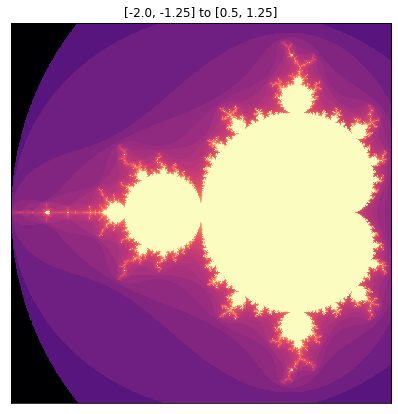

In [5]:
mandelbrot_image(mandel_set1)

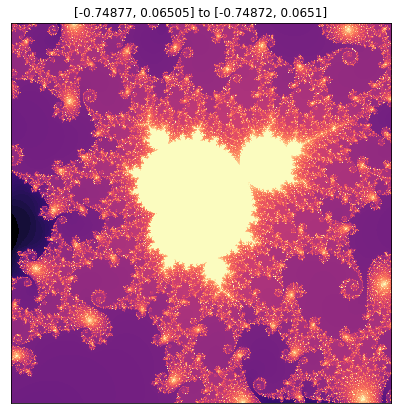

In [8]:
mandelbrot_image(mandel_set1, -0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

So what is taking so long? Let's profile the code:

In [9]:
p = %prun -r -q mandel_set1()
p.stream = sys.stdout
p.sort_stats('cumulative').print_stats(5)

          25214601 function calls in 8.835 seconds

   Ordered by: cumulative time
   List reduced from 9 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.835    8.835 {built-in method builtins.exec}
        1    0.002    0.002    8.835    8.835 <string>:1(<module>)
        1    0.516    0.516    8.832    8.832 <ipython-input-4-2accf7202ab4>:13(mandel_set1)
  1000000    6.001    0.000    8.311    0.000 <ipython-input-4-2accf7202ab4>:5(mandel1)
 24214592    2.310    0.000    2.310    0.000 {built-in method builtins.abs}




Simpler, but with less control over the output

In [10]:
%prun -s cumulative mandel_set1()

         25214601 function calls in 8.747 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.747    8.747 {built-in method builtins.exec}
        1    0.002    0.002    8.747    8.747 <string>:1(<module>)
        1    0.520    0.520    8.745    8.745 <ipython-input-4-2accf7202ab4>:13(mandel_set1)
  1000000    5.904    0.000    8.220    0.000 <ipython-input-4-2accf7202ab4>:5(mandel1)
 24214592    2.316    0.000    2.316    0.000 {built-in method builtins.abs}
        1    0.005    0.005    0.005    0.005 <ipython-input-4-2accf7202ab4>:16(<listcomp>)
        2    0.000    0.000    0.000    0.000 <ipython-input-4-2accf7202ab4>:1(linspace)
        2    0.000    0.000    0.000    0.000 <ipython-input-4-2accf7202ab4>:3(<listcomp>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

Again, the corresponding command line would be

```shell
$ python -m cProfile -s cumulative mandel01.py
```

However, for this to work, the script needs to be executable.

The profile above shows that most of the runtime is spent in the `mandel1` function. Let's get a line-by-line profile of that function

In [11]:
%load_ext line_profiler

In [12]:
%lprun -f mandel1 mandel_set1()

Timer unit: 1e-06 s

Total time: 34.5396 s
File: <ipython-input-4-2accf7202ab4>
Function: mandel1 at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def mandel1(c, maxiter):
     6   1000000     384562.0      0.4      1.1      z = c
     7  24463110    9552021.0      0.4     27.7      for n in range(maxiter):
     8  24214592   13255639.0      0.5     38.4          if abs(z) > 2:
     9    751482     294345.0      0.4      0.9              return n
    10  23463110   10960189.0      0.5     31.7          z = z*z + c
    11    248518      92873.0      0.4      0.3      return n

There is an algorithmic improvement that could be made here: Most of the time in this function is spent on calculating the absolute value and the value of the next iteration. Both of those involve redundant steps that can be factored out. Later on we will implement this, but for now let's try the simplest approach.

## Implementation 2: JIT compiling with numba

[Numba](https://numba.pydata.org/) is a `numpy` aware dynamic Python compiler using LLVM. It can speed up math-heavy, array oriented code with just some minor annotations. At the top of the notebook we imported the `jit` decorator from the numba package. The only modification to the code is decorating the `mandel` function. Note that numba cannot jit compile the current implementation of the `mandel_set` function due to the use of nested lists.

In [14]:
@jit(nopython=True)
def mandel2(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return n

def mandel_set2(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = linspace(xmin, xmax, width)
    i = linspace(ymin, ymax, height)
    n = [[0]*width for _ in range(height)]
    for x in range(width):
        for y in range(height):
            n[y][x] = mandel2(complex(r[x], i[y]), maxiter)
    return n

# warm up jit
_ = mandel_set2()

In [15]:
%timeit mandel_set2()

986 ms ± 858 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit mandel_set2(-0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

9.71 s ± 6.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now, reprofiling shows that the majority of the remaining runtime is spent in the `mandel_set` function

In [15]:
%prun -s cumulative mandel_set2()

         1000009 function calls in 2.280 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.280    2.280 {built-in method builtins.exec}
        1    0.002    0.002    2.280    2.280 <string>:1(<module>)
        1    1.772    1.772    2.277    2.277 <ipython-input-13-9aae54ac1ac3>:10(mandel_set2)
  1000000    0.498    0.000    0.498    0.000 <ipython-input-13-9aae54ac1ac3>:1(mandel2)
        1    0.006    0.006    0.006    0.006 <ipython-input-13-9aae54ac1ac3>:13(<listcomp>)
        2    0.000    0.000    0.000    0.000 <ipython-input-4-2accf7202ab4>:1(linspace)
        2    0.000    0.000    0.000    0.000 <ipython-input-4-2accf7202ab4>:3(<listcomp>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

Let's do a line profile on that

In [16]:
%lprun -f mandel_set2 mandel_set2()

Timer unit: 1e-06 s

Total time: 2.33788 s
File: <ipython-input-13-9aae54ac1ac3>
Function: mandel_set2 at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           def mandel_set2(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    11         1        263.0    263.0      0.0      r = linspace(xmin, xmax, width)
    12         1        235.0    235.0      0.0      i = linspace(ymin, ymax, height)
    13         1       5844.0   5844.0      0.2      n = [[0]*width for _ in range(height)]
    14      1001        683.0      0.7      0.0      for x in range(width):
    15   1001000     627705.0      0.6     26.8          for y in range(height):
    16   1000000    1703150.0      1.7     72.9              n[y][x] = mandel2(complex(r[x], i[y]), maxiter)
    17         1          1.0      1.0      0.0      return n

## Implementation 3: Numpy arrays

[Numpy](http://www.numpy.org/) is the fundamental Python array computation package. Numpy arrays are much more efficient that python lists or arrays. So does changing from lists to numpy arrays in the `mandel_set` function improve performance?

In [9]:
@jit(nopython=True)
def mandel3(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

def mandel_set3(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((height, width), dtype=int)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel3(complex(r[x], i[y]), maxiter)
    return n

# warm up jit
_ = mandel_set3()

In [10]:
%timeit mandel_set3()

1.3 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit mandel_set3(-0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

9.94 s ± 5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


No it did not - it actually is a bit slower. This might change with larger arrays. But either way, now we can jit compile it.

## Implementation 4: Numba jit compile the second function

Again, the only thing that has to change in the code is the `@jit` decorator. Note that for `np.empty`, `dtype=int` fails

In [17]:
@jit(nopython=True)
def mandel4(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return n

@jit(nopython=True)
def mandel_set4(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((height, width), dtype=np.int32)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel4(complex(r[x], i[y]), maxiter)
    return n

# warm up jit
_ = mandel_set4()

In [4]:
%timeit mandel_set4()

387 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit mandel_set4(-0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

9.14 s ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ah - that's better. Now the speedup is ~15-fold. Note: can't line_profile the jit functions

## Implementation 5: Improve the algorithm

The following are the definition of the square of complex numbers, the absolute value, and the sum of two complex numbers:

$$
\begin{aligned}
(a + bi)^2 &= (a + bi)(a + bi) = (a^2 - b^2) + 2abi \\
|a + bi| &= \sqrt{a^2 + b^2} \\
(a + bi) + (c + di) &= (a + c) + (b + d)i
\end{aligned}
$$

Based on this, we can factor out some redundant calculations by passing the real and imaginary parts of the complex numbers directly to the `mandel` function and calculating their squares separately only once and avoiding the square root computation.

In [6]:
@jit(nopython=True)
def mandel5(creal, cimag, maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2 * real*imag + cimag
        real = real2 - imag2 + creal       
    return n

@jit(nopython=True)
def mandel_set5(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((height, width), dtype=np.int32)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel5(r[x], i[y], maxiter)
    return n

# warm up jit
_ = mandel_set5()

In [7]:
%timeit mandel_set5()

102 ms ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit mandel_set5(-0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

2.64 s ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Checking that the results are still correct:

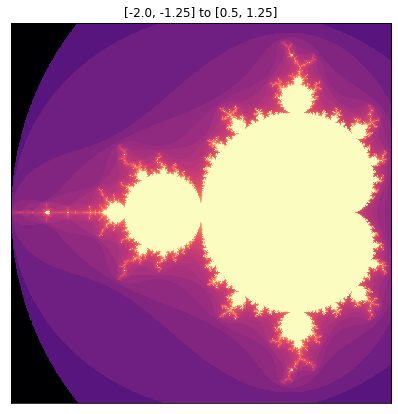

In [19]:
mandelbrot_image(mandel_set5)

And drawing the slower slice is much more pleasant now:

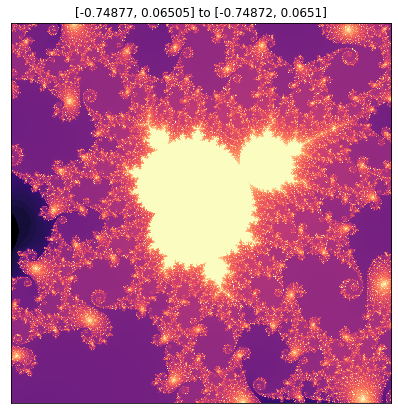

In [9]:
mandelbrot_image(mandel_set5, -0.74877, -0.74872, 0.06505, 0.06510, 1000, 1000, 2048)

## Implementation 6: Cython

[Cython](http://cython.org/) is a static compiler for Python plus the Cython extensions such as static type definitions. It generates C code that uses the Python C API to create C extensions.

How does a cythonized version of implementation 5 perform? To conveniently use cython code in a jupyter notebook, we'll load the cython extension first. Under the hood, this will generate C code, compile the extension module, and load it.

In [10]:
%load_ext cython

In [11]:
%%cython
import cython
import numpy as np

cdef int mandel6(double creal, double cimag, int maxiter):
    cdef:
        double real2, imag2
        double real = creal, imag = cimag
        int n

    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal;
    return n

@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef mandel_set6(double xmin, double xmax, double ymin, double ymax, int width, int height, int maxiter):
    cdef:
        double[:] r1 = np.linspace(xmin, xmax, width)
        double[:] r2 = np.linspace(ymin, ymax, height)
        int[:,:] n = np.empty((height, width), np.int32)
        int i,j
    
    for i in range(width):
        for j in range(height):
            n[j,i] = mandel6(r1[i], r2[j], maxiter)
    return n

In [12]:
%timeit mandel_set6(-2.0, 0.5, -1.25, 1.25, 1000, 1000, 80)

101 ms ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit mandel_set6(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

2.58 s ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


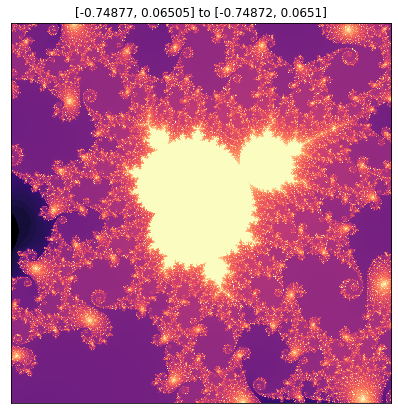

In [14]:
mandelbrot_image(mandel_set6, -0.74877,-0.74872,0.06505,0.06510,maxiter=2048)

## Implementation 7: GPU with pyopencl

Timing with [pyopencl](https://mathema.tician.de/software/pyopencl/) requires a GPU node and the CUDA module loaded on our systems. The /etc/OpenCL/vendors/ files had to be copied to the corresponding etc dir in the anaconda tree for the pyopencl conda package to recognize the GPU. We're skipping a CPU pyopencl test.

Note that pyopencl is not the only way to offload computation to a GPU. Numba and pycuda are other possibilities.


In [4]:
import pyopencl as cl
platforms = cl.get_platforms()
print(platforms)
ctx = cl.Context(
        dev_type=cl.device_type.ALL,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])

[<pyopencl.Platform 'NVIDIA CUDA' at 0x5555568b4fe0>]


In [5]:
def mandel7(q, maxiter):

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float real = q[gid].x;
        float imag = q[gid].y;
        output[gid] = maxiter;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real, imag2 = imag*imag;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 return;
            }
            imag = 2* real*imag + q[gid].y;
            real = real2 - imag2 + q[gid].x;
            
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandel_set7(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n = mandel7(c,maxiter)
    n = n.reshape((height, width))
    return n

In [7]:
%timeit mandel_set7(-2, 0.5, -1.25, 1.25, 1000, 1000, 80)

16.2 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit mandel_set7(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

36.4 ms ± 780 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


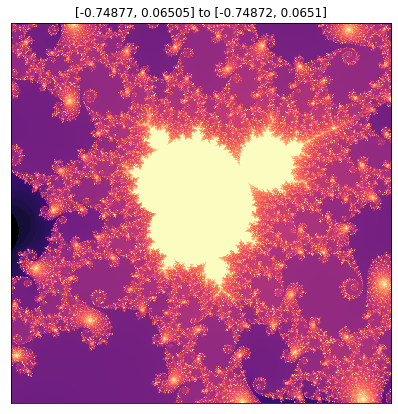

In [9]:
mandelbrot_image(mandel_set7, -0.74877,-0.74872,0.06505,0.06510,maxiter=2048)

## Implementation 8: Fortran

The `f2py` tool included with numpy can be used to bind fortran code to python. I don't have any fortran magic installed, so here is just the fortran code that implements the same algorithm:

In [10]:
%cat mandel08.f90

subroutine mandel_set8(xmin, xmax, ymin, ymax, width, height, itermax, n)
    real(8), intent(in)   :: xmin, xmax, ymin, ymax
    integer, intent(in)   :: width, height, itermax
    integer               :: niter
    integer, dimension(height, width), intent(out) :: n
    integer               :: x, y
    real(8)               :: xstep, ystep
    
    xstep = (xmax - xmin) / (width - 1)
    ystep = (ymax - ymin) / (width - 1)
    do x = 1, width
        do y = 1, height
            call mandel8(xmin + (x - 1) * xstep, ymin + (y - 1) * ystep, itermax, niter)
            n(y, x) = niter
        end do
    end do
end subroutine mandel_set8

subroutine mandel8(cre, cim, itermax, n)
    real(8), intent(in)      :: cre, cim
    integer, intent(in)      :: itermax
    integer, intent(out)     :: n
    real(8)                  :: re2, im2, re, im

    re = cre
    im = cim 
    do n = 0, itermax - 1
        re2 = re ** 2
        im2 = im ** 2
        if (re2 + im2 > 4.0) then
            exit


Which was compiled into the mb_fort module with

```shell
$ f2py -m mb_fort -c mandel08.f90 --fcompiler=gnu95
```

after which it can be imported

In [12]:
from mb_fort import mandel8, mandel_set8

In [13]:
%timeit mandel_set8(-2, 0.5, -1.25, 1.25, 1000, 1000, 80)

107 ms ± 60.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit mandel_set8(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

2.62 s ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


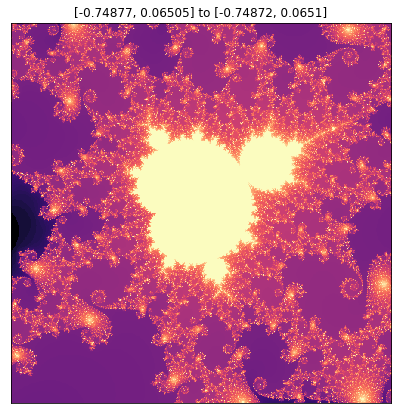

In [54]:
mandelbrot_image(mandel_set8, -0.74877,-0.74872,0.06505,0.06510, maxiter=2048)

## Implementation 9: Parallelism on CPU via numba vectorization

Numba provides the `vectorize` and `guvectorize` decorators to create numpy ufuncs that can also be parallelized by using a parallel or GPU backend. Reverting back to passing complex numbers. Note that `guvectorize` does not return a value - it takes an output argument. To benchmark this with different numbers
of threads, I'm saving the file and running in from the shell. Numba uses it's own environment variable to limit paralellism (`NUMBA_NUM_THREADS`). Note that while there is a `numba.config.NUMBA_NUM_THREADS`, setting it does not seem to affect the number of threads used by Numba.

In [19]:
%%writefile mandel09.py
from numba import jit, vectorize, complex64, int32
import numpy as np

@vectorize([int32(complex64, int32)], target='parallel')
def mandel9(c, maxiter):
    nreal = 0
    real = 0
    imag = 0
    for n in range(maxiter):
        nreal = real*real - imag*imag + c.real
        imag = 2* real*imag + c.imag
        real = nreal;
        if real * real + imag * imag > 4.0:
            return n
    return n
        
def mandel_set9(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n = mandel9(c,maxiter)
    return n

Overwriting mandel09.py


In [20]:
%%bash
expr='mandel09.mandel_set9(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)'
for threads in 1 2 4 8 14; do
    printf "%3i threads\n" ${threads}
    NUMBA_NUM_THREADS=${threads} python -m timeit -s 'import mandel09' "$expr"
done

  1 threads
10 loops, best of 3: 2.71 sec per loop
  2 threads
10 loops, best of 3: 1.36 sec per loop
  4 threads
10 loops, best of 3: 679 msec per loop
  8 threads
10 loops, best of 3: 358 msec per loop
 14 threads
10 loops, best of 3: 244 msec per loop


That scales so so. With 1 thread it's about as fast as implementation 5. With 4 threads the efficiency is 63%. With 14 threads it drops to ~50%.

## Implementation 10: Multiprocessing

The multiprocessing module emphasizes avoiding shared state, so we'll stick with that.  For simplicity we'll use python lists to begin with to see how good performance is. Since communication has overhead, we'll break the computation up such that each task returns a row.
Note that on linux `fork` is the default way of starting subprocesses. In that case we can get away with not making the main module safely importable. Generally speaking though it's better to do so.

In [21]:
import multiprocessing as mp

ncpus = 1
@jit(nopython=True)
def mandel10(creal, cimag, maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2 * real*imag + cimag
        real = real2 - imag2 + creal       
    return n

@jit(nopython=True)
def mandel10_row(args):
    y, xmin, xmax, width, maxiter = args
    r = np.linspace(xmin, xmax, width)
    res = [0] * width
    for x in range(width):
        res[x] = mandel10(r[x], y, maxiter)
    return res
        

def mandel_set10(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    i = np.linspace(ymin, ymax, height)
    with mp.Pool(ncpus) as pool:
        n = pool.map(mandel10_row, ((a, xmin, xmax, width, maxiter) for a in i))
    return n

In [22]:
for i in (1, 2, 4, 8, 14):
    ncpus = i
    %timeit mandel_set10(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

3.03 s ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.66 s ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.04 s ± 744 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
764 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
818 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


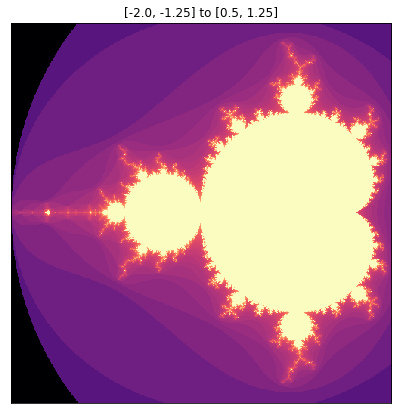

In [47]:
mandelbrot_image(mandel_set10, -2.0, 0.5, -1.25, 1.25)

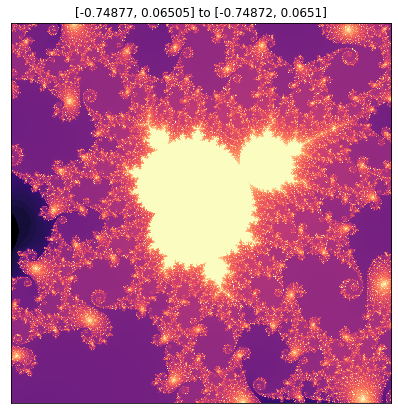

In [23]:
mandelbrot_image(mandel_set10, -0.74877,-0.74872,0.06505,0.06510, maxiter=2048)